In [1]:
import numpy as np
import scipy.linalg as la
import scipy.spatial as spat
import math
import matplotlib.pyplot as plt
from braket.circuits import Circuit, circuit
from braket.devices import LocalSimulator
from braket.aws import AwsDevice

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
def find_probability(eigenvector):
    count_total = np.sum(eigenvector)
    
    eigenvector = eigenvector / count_total
    
    return eigenvector

In [3]:
def find_amplitude(eigenvector):
    eigenvector = np.sqrt(eigenvector)
    
    return eigenvector

In [4]:
def find_eigen_vec(result, num_vec_bit, num_val_bit):
    
    total_counts = 0
    
    counts = result['measurement_counts']
    
    assert num_vec_bit < 10, "Error: the code is only programmed for num_vec_bit < 10"
    
    eigenvector = np.zeros(2**num_vec_bit)
    
    eigenvalue = ''
    
    for i in range(num_val_bit):
        eigenvalue = eigenvalue + '0'
    
    for i in range(2**num_vec_bit):
        bformat = '{0:0' + str(num_vec_bit) + 'b}'
        #eigenvec_string = bformat.format(i) + eigenvalue
        eigenvec_string = eigenvalue + bformat.format(i) 
        
        eigenvector[i] = counts[eigenvec_string]
        total_counts = total_counts + counts[eigenvec_string]
    
    eigenvector = find_probability(eigenvector)
    
    eigenvector = find_amplitude(eigenvector)
    
    return eigenvector, total_counts

In [5]:
@circuit.subroutine(register=True)
def inverse_qft(qubits):
    qftcirc = Circuit()
    num_qubits = len(qubits)

    for i in range(math.floor(num_qubits / 2)):
        qftcirc.swap(qubits[i], qubits[-i - 1])

    for k in reversed(range(num_qubits)):
        for j in reversed(range(1, num_qubits - k)):
            angle = -2 * math.pi / (2 ** (j + 1))
            qftcirc.cphaseshift(qubits[k + j], qubits[k], angle)
        qftcirc.h(qubits[k])
    return qftcirc

In [6]:
# general imports
import math
import pickle
from collections import Counter
from datetime import datetime
from braket.devices import LocalSimulator
import numpy as np
from braket.circuits import Circuit, circuit
# from utils_qft import inverse_qft

@circuit.subroutine(register=True)
def controlled_unitary(control, target_qubits, unitary):
    # Define projectors onto the computational basis
    p0 = np.array([[1.0, 0.0], [0.0, 0.0]])
    p1 = np.array([[0.0, 0.0], [0.0, 1.0]])
    circ = Circuit()

    # Construct numpy matrix
    id_matrix = np.eye(len(unitary))
    controlled_matrix = np.kron(p0, id_matrix) + np.kron(p1, unitary)
    targets = [control] + target_qubits
    
    circ.unitary(matrix=controlled_matrix, targets=targets)

    return circ


@circuit.subroutine(register=True)
def qpe(precision_qubits, query_qubits, unitary, control_unitary=True):
    qpe_circ = Circuit()
    num_precision_qubits = len(precision_qubits)
    num_query_qubits = len(query_qubits)
    qpe_circ.h(precision_qubits)
    for ii, qubit in enumerate(reversed(precision_qubits)):
        power = ii
        if control_unitary:
            Uexp = np.linalg.matrix_power(unitary, 2 ** power)
            qpe_circ.controlled_unitary(qubit, query_qubits, Uexp)
        else:
            for _ in range(2 ** power):
                qpe_circ.controlled_unitary(qubit, query_qubits, unitary)
    qpe_circ.inverse_qft(precision_qubits)

    return qpe_circ


def substring(key, precision_qubits):
    short_key = ""
    for idx in precision_qubits:
        short_key = short_key + key[idx]

    return short_key

def binaryToDecimal(binary):
    length = len(binary)
    fracDecimal = 0
    twos = 2

    for ii in range(length):
        fracDecimal += (ord(binary[ii]) - ord("0")) / twos
        twos *= 2.0
    return fracDecimal


def get_qpe_phases(measurement_counts, precision_qubits, items_to_keep=1):
    bitstrings_precision_register = [
        substring(key, precision_qubits) for key in measurement_counts.keys()
    ]
    bitstrings_precision_register_set = set(bitstrings_precision_register)
    bitstrings_precision_register_list = list(bitstrings_precision_register_set)
    precision_results_dic = {key: 0 for key in bitstrings_precision_register_list}

    for key in measurement_counts.keys():
        counts = measurement_counts[key]
        count_key = substring(key, precision_qubits)
        precision_results_dic[count_key] += counts

    c = Counter(precision_results_dic)
    topmost = c.most_common(items_to_keep)
    phases_decimal = [binaryToDecimal(item[0]) for item in topmost]

    return phases_decimal, precision_results_dic


def run_qpe(
    unitary,
    precision_qubits,
    query_qubits,
    query_circuit,
    items_to_keep=1,
    shots=1000
):
    circ = query_circuit
    circ.qpe(precision_qubits, query_qubits, unitary, control_unitary=False)

    # Add desired results_types
    
    number_precision_qubits = len(precision_qubits)
    
    num_qubits = len(precision_qubits)
    circ.probability(np.array(precision_qubits))
    device = LocalSimulator()
    task=device.run(circ,shots=shots)
    result=task.result()
    metadata = result.task_metadata

    probs_values = result.values[0]
    measurements = result.measurements
    measured_qubits = result.measured_qubits
    measurement_counts = result.measurement_counts
    measurement_probabilities = result.measurement_probabilities
    format_bitstring = "{0:0" + str(num_qubits) + "b}"
    bitstring_keys = [format_bitstring.format(ii) for ii in range(2 ** num_qubits)]


    phases_decimal, precision_results_dic = get_qpe_phases(
        measurement_counts, precision_qubits, items_to_keep
    )
    
    print('\nPhases:',phases_decimal)
    
    eigenvalues = [np.exp(2 * np.pi * 1j * phase) for phase in phases_decimal]

    # aggregate results
    out = {
        "circuit": circ,
        "task_metadata": metadata,
        "measurements": measurements,
        "measured_qubits": measured_qubits,
        "measurement_counts": measurement_counts,
        "measurement_probabilities": measurement_probabilities,
        "probs_values": probs_values,
        "bitstring_keys": bitstring_keys,
        "precision_results_dic": precision_results_dic,
        "phases_decimal": phases_decimal,
        "eigenvalues": eigenvalues,
    }

    return out

In [7]:
def postprocess_qpe_results(out,printcir=True):
    """
    Function to postprocess dictionary returned by run_qpe

    Args:
        out: dictionary containing results/information associated with QPE run as produced by run_qpe
    """
    
    # unpack results
    circ = out['circuit']
    measurement_counts = out['measurement_counts']
    bitstring_keys = out['bitstring_keys']
    probs_values = out['probs_values']
    precision_results_dic = out['precision_results_dic']
    phases_decimal = out['phases_decimal']
    eigenvalues = out['eigenvalues']
    
    # print the circuit 
    if printcir:
        print('Printing circuit:')
        print(circ)
    
    # print measurement results
    print('\nMeasurement counts:', measurement_counts)
    
    # plot probabalities
    plt.bar(bitstring_keys, probs_values);
    plt.xlabel('bitstrings');
    plt.ylabel('probability');
    plt.xticks(rotation=90);

    return eigenvalues

In [8]:
def fidelity_check(qeigvals,aeigvals,runit):
    qeigvals.sort()
    aeigvals.sort()
    qmat=np.matrix(qeigvals).round(runit)
    amat=np.matrix(aeigvals).round(runit)
    
    print('\n\nResults:')
    print('Actual Eigen Values: ',amat)
    print('Quantum Eigen Values:',qmat)
    
    qmat=np.real(qmat)
    amat=np.real(amat)
    
    cosine_similarity = 1 - spat.distance.cosine(qmat, amat)
    
    print('Fidelity:',round(cosine_similarity,runit))

In [9]:
def estimate_phase(n,unitary,runit, shots = 1000, printcir=True):
    print('Unitary: \n',np.matrix(unitary).round(runit))
    eig_values, eig_vectors = np.linalg.eig(unitary)
    elen=len(eig_values)
    
    number_precision_qubits = n

    precision_qubits = range(number_precision_qubits)
    
    if elen==2:
        query_qubits = [number_precision_qubits]
    else:
        query_qubits = [number_precision_qubits, number_precision_qubits+1]

    query = Circuit().h(query_qubits)

    result = run_qpe(unitary, precision_qubits, query_qubits, query, items_to_keep=elen, shots = shots)
    qeigvals= postprocess_qpe_results(result,printcir)
    
    fidelity_check(qeigvals,eig_values,runit)
    
    return result

[[ 0.58999765+0.29518442j -0.0136514 -0.11995404j -0.44706041+0.46050425j
  -0.34529775-0.13797062j]
 [ 0.38249852+0.28511011j  0.03629133-0.11584219j  0.00683583-0.43683978j
   0.04436532+0.75154949j]
 [ 0.46256708-0.1692794j   0.63192448-0.01111013j  0.27743665-0.34260477j
  -0.03043102-0.4032977j ]
 [-0.04745551+0.30380948j  0.053358  -0.75391587j  0.36372797+0.2656124j
   0.3535746 -0.079678j  ]]
Unitary: 
 [[ 0.59   +0.29518j -0.01365-0.11995j -0.44706+0.4605j  -0.3453 -0.13797j]
 [ 0.3825 +0.28511j  0.03629-0.11584j  0.00684-0.43684j  0.04437+0.75155j]
 [ 0.46257-0.16928j  0.63192-0.01111j  0.27744-0.3426j  -0.03043-0.4033j ]
 [-0.04746+0.30381j  0.05336-0.75392j  0.36373+0.26561j  0.35357-0.07968j]]

Phases: [0.125, 0.8125, 0.0, 0.0625]
Printing circuit:
T  : |0|1|2|3|4|5|6|7|  8   |9|10|11|12|13|14|15| 16 |17|     18     |      19       |            20            |      21       |     22     |23|Result Types|
                                                                     

{'circuit': Circuit('instructions': [Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(4)])), Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(5)])), Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(0)])), Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(1)])), Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(2)])), Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(3)])), Instruction('operator': Unitary('qubit_count': 3), 'target': QubitSet([Qubit(3), Qubit(4), Qubit(5)])), Instruction('operator': Unitary('qubit_count': 3), 'target': QubitSet([Qubit(2), Qubit(4), Qubit(5)])), Instruction('operator': Unitary('qubit_count': 3), 'target': QubitSet([Qubit(2), Qubit(4), Qubit(5)])), Instruction('operator': Unitary('qubit_count': 3), 'target': QubitSet([Qubit(1), Qubit(4), Qubit(5)])), Instruction('operator': Unitary('qubit_count': 3), 'target': QubitSet([Qubit(1)

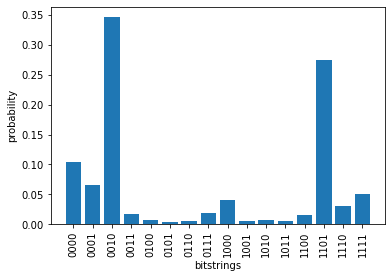

In [10]:
from scipy.stats import unitary_group
import numpy as np
np.random.seed(seed=3000)

unitary1 = unitary_group.rvs(4)
print(unitary1)
estimate_phase(4,unitary1,5,printcir=True)

In [14]:
"""
Purpose: 
    Find the analytical solution given the input parameters
Input: 
    x: array representing the x coordinates over which the solution is to be found
    a, Γ: parameters for the Ornstein-Uhlenbeck equation
Output:
    y: array of the value of the analytical solution over x
"""

def OrnsteinUhlenbeck(x, a = 1, Γ = 1):
    y = np.sqrt(a/(2*np.pi*Γ)) * np.exp((-a * x ** 2)/(2*Γ))
    
    return y

In [15]:
"""
Purpose:
    Calculate the weighted Hermite polynomials using recursive relations up to H_n
Input:
    n: the highest number of Hermite polynomials to be evaluated at
    x: the value of x at which the weighted Hermite polynomials are to be evaluated
Output:
    Hermite: the value of the weighted Hermite polynomials
Example: HermiteSeries(2, 4) -> [H_0(4), H_1(4), H_2(4)]
"""

def HermiteSeries(n, x):
    Hermite = np.zeros((1, n+1))
    Hermite[0][0] = 1.0 * np.exp(-x**2/2)
    Hermite[0][1] = 2.0 * x *np.exp(-x**2/2)
    
    for ni in range(1, n):
        Hermite[0][ni+1] = 2*x*Hermite[0][ni] - 2*ni*Hermite[0][ni-1]
    
    return Hermite

In [16]:
"""
Purpose:
    Reconstruct the functions represented by the coefficients of weighted Hermite polynomials in spatial coordinates
Input:
    x: array containing the x values over which the function is to be evaluated
    coefficients: the coefficients corresponding to the Hermite polynomials (should be zero-mode of the operator)
    nmax: the highest order of weighted Hermite polynomials used
    s: the scaling factor
Output:
    y: the reconstruction
"""

def project(x, coefficients, nmax, s):
    
    y = np.zeros(x.shape)
    
    for i in (range(len(x))):
        x0 = s*x[i]
        hermite_values = HermiteSeries(nmax, x0)
        y[i] += np.dot(hermite_values, coefficients)
        
    return (x, y)

In [17]:
"""
Purpose:
    Normalize the PDF so that the area under the curve is 1
Input:
    x, y: arrays representing the unnormalized
Output:
    (x, y): normalized PDF
"""

def normalize(x, y):
    dx = x[1] - x[0]
    sum = 0
    
    for i in range(len(x)):
        sum = sum + (y[i] * dx)
    
    y = y/sum
    
    return (x, y)

In [18]:
"""
Purpose:
    Calculate the RMS
Input:
    y_op, y: the y values generated by the operator and the analytical solution
Output:
    RMS
"""

def rms_diff(y_op, y):
    return np.sqrt(np.sum((y_op-y)**2)/len(y))

In [19]:
"""
Purpose:
    Find s given a and Γ such that the projection in Hermite space is just H_0
Input:
    a, Γ: parameters for Ornstein-Uhlenbeck
Output:
    s
"""

def special_s(a, Γ):
    return np.sqrt(a/Γ)

Unitary: 
 [[ 1.00000000e+00+4.58544878e-34j  0.00000000e+00+0.00000000e+00j
   3.03637015e-17-2.06510254e-17j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  9.06310151e-01-4.18366823e-01j
   0.00000000e+00+0.00000000e+00j -2.60429577e-03-5.97019972e-02j]
 [ 3.03637015e-17-2.06510254e-17j  0.00000000e+00+0.00000000e+00j
  -3.67459549e-01+9.30039504e-01j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -2.60429577e-03-5.97019972e-02j
   0.00000000e+00+0.00000000e+00j  9.39297898e-01+3.37858474e-01j]]

Phases: [0.0, 0.9375, 0.3125, 0.0625]

Measurement counts: Counter({'0000000': 250759, '1111001': 244254, '0101010': 244079, '0001011': 180173, '1110101': 19968, '0000111': 13586, '1111101': 8760, '0001111': 5988, '1110001': 3720, '0000001': 2889, '0000011': 2367, '0100110': 1971, '0000101': 1859, '0010011': 1829, '1101101': 1548, '0101110': 1455, '1110111': 962, '0010111': 955, '1101001': 844, '1111111': 724, '0011011': 595, '1100101': 530, '0100010'

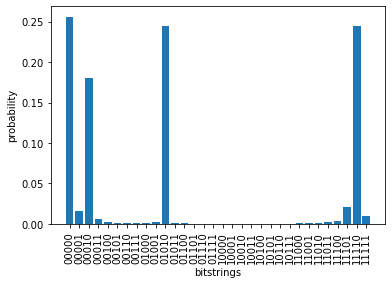

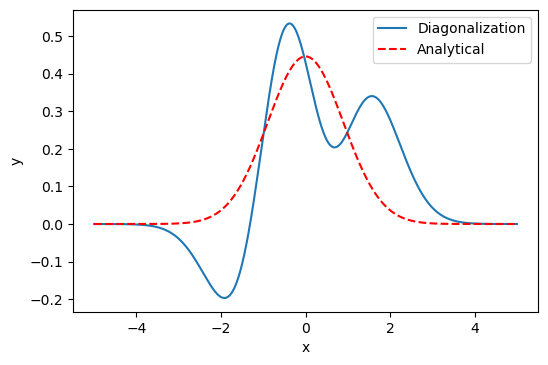

In [27]:
"""
Naming conventions for file:

Files begining with sol indicates that it's the eigenmode found using classical algorithms

L_dag indicates that the matrix contained in the file is Hermitian using L^dag * L
L-double indicates that the matrix contained in teh file is Hermitian using [[0, L], [L^dag, 0]]

n is followed by the highest Hermite polynomial used (e.g. n = 3 indicates that H_0, H_1, H_2, H_3 are used)
    for L_dag matrices, this results in a (n+1)x(n+1) sized matrix
    for L_double matrix, this results in a 2*(n+1)x2*(n+1) matrix

a is followed by the value used for a
gamma is followed by the value used for Γ
s is followed by the scaling constant (e.g. 1-5 means 1.5)

first indicates that s is chose such that the eigenmode should be only the H_0, use special_s to find the value of s
"""

L_dag0 = np.load("matrix/L_dag_n3_a10_gamma8_first.npz")
L_dag_sol0 = np.load("matrix/sol_L_dag_n3_a10_gamma8_first.npz")

import numpy as np
matrix0 = np.load("matrix/L_dag_n3_a10_gamma8_first.npz")
vec0 = np.load("matrix/sol_L_dag_n3_a10_gamma8_first.npz")
eM = la.expm(1j*matrix0)

vec0

nmax = 3
a = 10
Γ = 8
s = special_s(a, Γ)

result = estimate_phase(5, eM, 100, shots = 1_000_000, printcir=False)

coefficients, count_total = find_eigen_vec(result, 2, 5)

print("count_total=", count_total)
print("coefficients=", coefficients)

x = np.linspace(-5, 5, 1001)
y = OrnsteinUhlenbeck(x, a, Γ)

(x_op, y_op) = project(x, coefficients, nmax, s)
(x_op, y_op) = normalize(x_op, y_op)
print("rms diff: " + str(rms_diff(y_op, y)))

plt.figure(dpi = 100)

plt.plot(x_op, y_op, label = "Diagonalization")
plt.plot(x, y, "r--", label = "Analytical")


plt.xlabel("x")
plt.ylabel("y")

plt.legend()
plt.savefig('probability0.png')